In [1]:
# !apt-get --purge remove cuda nvidia* libnvidia-*
# !dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
# !apt-get remove cuda-*
# !apt autoremove
# !apt-get update
# !wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
# !dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
# !apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
# !apt-get update
# !apt-get install cuda-9.2
# !pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
# %load_ext nvcc_plugin

In [2]:
# Install libAUC and medMNIST
!pip install libauc==1.2.0
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 2.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116952 sha256=b1de1d00813fafb1c6696ed2df9db5c4731e6d8233fdfe11780ee231dea02008
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [3]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator

In [4]:
# Load pneumoniaMNIST
data_flag = 'pneumoniamnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from libauc.losses import AUCMLoss
from libauc.optimizers import PESG
from libauc.metrics import auc_roc_score

from sklearn.metrics import roc_auc_score
import random

random_seed = 41
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

BATCH_SIZE = 64
imratio = 0.1  # for demo
total_epochs = 120
#decay_epochs = [50, 75]

# Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(3),
    # transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load the data
train_dataset = DataClass(split='train', transform=transform_train, download=download)
test_dataset = DataClass(split='test', transform=transform_test, download=download)
val_dataset = DataClass(split='val', transform=transform_val, download=download)

# Encapsulate data into dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

# Instantiate the ResNet-18 model[Single Channel] and set it to training mode
model = torchvision.models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    # nn.Dropout(p=0.1),
    nn.Linear(num_ftrs, 2)
)

# Define loss function and optimizer
loss_fn = AUCMLoss()
optimizer = PESG(model, loss_fn=loss_fn, momentum=0.8, margin=1.0, epoch_decay=0.03, lr=0.01, weight_decay=1e-5)

# Set early stopping parameters
early_stop_epochs = 15  # Stop if validation AUC does not improve for 10 epochs
best_val_auc = 0
epochs_since_last_improvement = 0

# Training loop
print('Start Training')
print('-'*30)

train_log = []
test_log = []
val_log = []
for epoch in range(total_epochs):
    train_loss = []
    model.train()
    for data, targets in train_loader:
        y_pred = model(data)
        loss = loss_fn(y_pred, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    # Evaluation on train & test sets
    model.eval()
    train_pred_list = []
    train_true_list = []
    for train_data, train_targets in train_loader_at_eval:
        train_pred = model(train_data)
        train_pred_list.append(train_pred.cpu().detach().numpy())
        train_true_list.append(train_targets.numpy())
    train_true = np.concatenate(train_true_list)
    train_pred = np.concatenate(train_pred_list)
    train_auc = auc_roc_score(train_true, train_pred)
    train_loss = np.mean(train_loss)

    val_pred_list = []
    val_true_list = []
    for val_data, val_targets in val_loader:
         val_pred = model(val_data)
         val_pred_list.append(val_pred.cpu().detach().numpy())
         val_true_list.append(val_targets.numpy())
    val_true = np.concatenate(val_true_list)
    val_pred = np.concatenate(val_pred_list)
    val_auc =  auc_roc_score(val_true, val_pred)

    test_pred_list = []
    test_true_list = []
    for test_data, test_targets in test_loader:
         test_pred = model(test_data)
         test_pred_list.append(test_pred.cpu().detach().numpy())
         test_true_list.append(test_targets.numpy())
    test_true = np.concatenate(test_true_list)
    test_pred = np.concatenate(test_pred_list)
    test_auc =  auc_roc_score(test_true, test_pred) 
    model.train()

    # print results
    print("epoch: %s, train_loss: %.4f, train_auc: %.4f, val_auc: %.4f, test_auc: %.4f, lr: %.4f"%(epoch, train_loss, train_auc[0], val_auc[0], test_auc[0], optimizer.lr ))    
    train_log.append(train_auc[0]) 
    test_log.append(val_auc[0])

    # Check for early stopping
    if val_auc[0] > best_val_auc:
        best_val_auc = val_auc[0]
        best_test_auc = test_auc[0] #Test AUC corresponding to best Val AUC
        epochs_since_last_improvement = 0
    else:
        epochs_since_last_improvement += 1
        if epochs_since_last_improvement >= early_stop_epochs:
            print(f"No improvement in validation AUC for {early_stop_epochs} epochs. Training stopped early.")
            break


100%|██████████| 4170669/4170669 [00:00<00:00, 4766629.52it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Start Training
------------------------------
epoch: 0, train_loss: 2.7861, train_auc: 0.9599, val_auc: 0.9500, test_auc: 0.9049, lr: 0.1000
epoch: 1, train_loss: 0.0295, train_auc: 0.9665, val_auc: 0.9532, test_auc: 0.9044, lr: 0.1000
epoch: 2, train_loss: 0.0235, train_auc: 0.9823, val_auc: 0.9717, test_auc: 0.9051, lr: 0.1000
epoch: 3, train_loss: 0.0212, train_auc: 0.9680, val_auc: 0.9496, test_auc: 0.8855, lr: 0.1000
epoch: 4, train_loss: 0.0194, train_auc: 0.9815, val_auc: 0.9724, test_auc: 0.8970, lr: 0.1000
epoch: 5, train_loss: 0.0188, train_auc: 0.9905, val_auc: 0.9859, test_auc: 0.9369, lr: 0.1000
epoch: 6, train_loss: 0.0181, train_auc: 0.9787, val_auc: 0.9678, test_auc: 0.8824, lr: 0.1000
epoch: 7, train_loss: 0.0175, train_auc: 0.9829, val_auc: 0.9792, test_auc: 0.8816, lr: 0.1000
epoch: 8, train_loss: 0.0152, train_auc: 0.9912, val

In [9]:
print(best_test_auc)
print(train_dataset)
print("===================")
print(test_dataset)

0.9455402147709842
Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 624
    Root location: /root/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumo

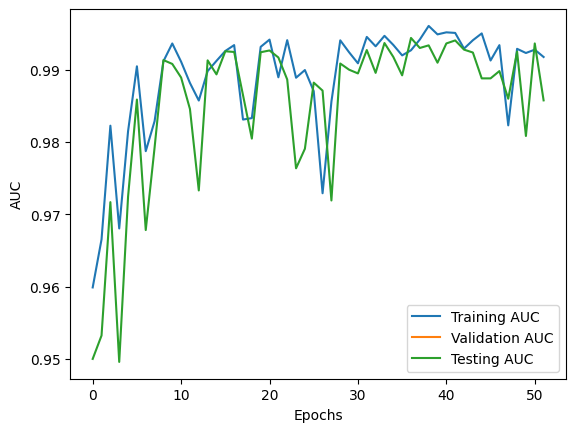

In [7]:
import matplotlib.pyplot as plt

plt.plot(train_log, label='Training AUC')
plt.plot(val_log, label='Validation AUC')
plt.plot(test_log, label='Testing AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()


In [8]:
print("Final Validation AUC:", best_val_auc)
print("Final Test AUC:", best_test_auc)


Final Validation AUC: 0.994420641721413
Final Test AUC: 0.9455402147709842
